# <i>Survival Analysis III</i>
## <i>Cox Proportional Hazards Model</i>

There are a few popular models in survival regression: Cox's model, accelerated failure models, and Aalen's additive model. All models attempt to represent the hazard rate $h(t|x)$ as a function of $t$ and some covariates $X$.
    
The semi-parametric Cox proportional hazards model produces $\beta_i$ coefficients of the independent variables, and non-negative hazard estimates, without making strong assumptions about the data the way that parametric methods do.

The hazard and survival functions $h(t,X)$ and $S(t,X)$ can be estimated, but the Cox model cannot directly handle left-censored or interval-censored data.

The Cox proportional hazards model expresses the hazard at time $t$ as the product of a baseline hazard function (i.e., with explanatory variables excluded) and the exponential of a term that is linear in its predictors. In other words, the expression is divided into one term depending on time only, and one term depending on the time-independent $X_i$s.

The hazard function for the Cox proportional hazards model is:

<h1>$\underbrace{h(t|X)} = \overbrace{h_0(t)} \underbrace{ exp(\sum_{i=1}^p \beta_i X_i) }$</h1>

- $h_0(t)$ is the baseline hazard, the probability of experiencing the event of interest when all covariates equal $0$
- $X$ is the predictor variables
- $p$ is the number of predictors
- $\beta$ is the vector of coefficients

### Import Libraries and Data

In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = lifelines.datasets.load_gbsg2()
print(np.shape(data))
data.head()

(686, 10)


,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


### Preprocessing

There are categorical variables, which we will need to convert to numeric if we are to use them in a regression model.

In [2]:
print(data['horTh'].value_counts())
print()
print(data['menostat'].value_counts())
print()
print(data['tgrade'].value_counts())

no     440
yes    246
Name: horTh, dtype: int64

Post    396
Pre     290
Name: menostat, dtype: int64

II     444
III    161
I       81
Name: tgrade, dtype: int64


##### Label-Encoding

horTh and menostat only have two categories, so we can use label-encoding. Tumor grade has three categories, and will require one-hot encoding.

In [3]:
data['horTh'] = data['horTh'].map({'no': 0, 'yes': 1})
data['menostat'] = data['menostat'].map({'Pre': 0, 'Post': 1})

##### One-Hot Encoding

In [4]:
dummies = pd.get_dummies(data['tgrade'], drop_first=True)
data = pd.concat([data, dummies], axis=1)
data.drop(columns=['tgrade'], inplace=True)
data = data.rename(columns={'II': 'tgrd2', 'III': 'tgrd3'})
data.head(2)

,horTh,age,menostat,tsize,pnodes,progrec,estrec,time,cens,tgrd2,tgrd3
0,0,70,1,21,3,48,66,1814,1,1,0
1,1,56,1,12,7,61,77,2018,1,1,0


### Cox Proportional Hazards Model

Here, a Cox PH model is fitted, and a summary of results printed.

In [5]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='cens')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2023-09-03 21:46:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
horTh      -0.35       0.71       0.13            -0.60            -0.09                 0.55                 0.91
age        -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
menostat    0.26       1.29       0.18            -0.10             0.62                 0.90                 1.86
tsize       0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
pnodes      0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
progrec    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
estrec      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
tgrd2       0.64       1.89       0.25             0.15             1.12                 1.16                 3.08
tgrd3       0.78       2.18       0.27             0.25             1.31                 1.29                 3.69

            cmp to     z      p   -log2(p)
covariate                                 
horTh         0.00 -2.68   0.01       7.10
age           0.00 -1.02   0.31       1.69
menostat      0.00  1.41   0.16       2.65
tsize         0.00  1.98   0.05       4.39
pnodes        0.00  6.55 <0.005      34.03
progrec       0.00 -3.87 <0.005      13.14
estrec        0.00  0.44   0.66       0.60
tgrd2         0.00  2.55   0.01       6.55
tgrd3         0.00  2.90 <0.005       8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01

Most variables were significant at $\alpha \lt 0.05$, though 3 were not, according to the p-values. The metrics at the bottom of the summary provide overall comparability to other models, and a couple of them will soon be described in depth.

The Cox fitter has a nice <code>plot</code> function which can be very informative, and below plots the magnitude of coefficients for each of the variables, along with each of their confidence intervals.

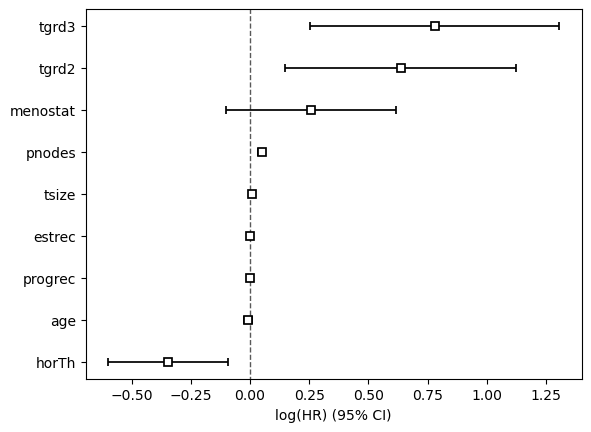

In [6]:
cph.plot();

The Cox PH model includes the following parameters:
- <code>penalizer</code>: attaches a penalty to the size of the coefficients, default of 0. This improves stability with correlated features
- <code>l1_ratio</code>: ratio to assign to a L1 vs L2 penalty

# The Proportional Hazards Assumption

The proportional hazards assumption is the assumption that covariates have a linear, multiplicative effect on the hazard function, and that the effect stays the same across time. The three assumptions made by the Cox model are that:

1. The hazard ratio of two subjects remains the same at all times
2. The explanatory variables act multiplicatively on the hazard function
3. Failure times of individual subjects are independent of each other

Methods of checking the data for compliance with the proportional hazards assumption include graphical analysis, plots of observed vs. Kaplan-Meier expected values, checking with time-dependent covariates, and goodness-of-fit tests.

Below is one of many alternatives for proportional hazard testing, that assigns p-values to describe the compliance of each variable to the assumption. You can read about this and the other tests lifelines offers <a href="https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html">here</a>.

In [7]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
age                 2.79 0.09      3.40
estrec              1.42 0.23      2.10
horTh               0.21 0.65      0.63
menostat            0.01 0.94      0.08
pnodes              0.57 0.45      1.16
progrec             1.08 0.30      1.74
tgrd2               1.83 0.18      2.51
tgrd3               5.86 0.02      6.02
tsize               0.18 0.67      0.58

In [9]:
cph.concordance_index_

0.6918510280149093

The next article is about parametric survival models; you can find it **here**

# References

1. (n.d.). Lifelines Documentation. Lifelines. https://lifelines.readthedocs.io/en/latest/
2. Moore, D. F. (2016). Applied Survival Analysis in R. Springer International Publishing Switzerland 2016.
3. (n.d.). Scikit-Survival Documentation. https://scikit-survival.readthedocs.io/en/stable/user_guide/index.html
4. [Udemy]. (2019, April 1). Survival Analysis in R [Video]. Udemy. https://www.udemy.com/course/survival-analysis-in-r/
5. (2019, January 6). Survival Analysis Intuition and Implementation in Python. Towards Data Science. https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
6. Lewinson, E. (2020, August 17). Introduction to Survival Analysis: The Kaplan-Meier estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-kaplan-meier-estimator-94ec5812a97a
7. Lewinson, E. (2020, July 23). The Cox Proportional Hazards Model. Towards Data Science. https://towardsdatascience.com/the-cox-proportional-hazards-model-35e60e554d8f
8. Lewinson, E. (2020, August 23). Introduction to Survival Analysis: The Nelson-Aalen estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-nelson-aalen-estimator-9780c63d549d